In this notebook, we'll run PyBDSF's polarisation module on some ASKAP polarisation data. We'll use one of the RACS beams.

PyBDSF seems to want IQUV to work on polarisation, and according to the documentation it does all fitting on the Stokes I MFS image. Polarisation is calculated for each Stokes I source. Ideally, we want to do fitting on the total polarised intensity image, but for now we'll just see how well PyBDSF works doing what it does best.

In [2]:
import astropy.io.fits as fits
import numpy
import os
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import astropy.nddata
from astropy.wcs import WCS
import pandas
from IPython.display import display

In [3]:
os.environ['LD_LIBRARY_PATH']

'/home/alger/boost_1_68_0/stage/lib'

In [4]:
import bdsf

## Combine image

We'll use beam 4 from the POSSUM Busy Week 5 RACS Focus. We have four separate images (one for each Stokes channel), so we need to combine them into one cube — one obvious limitation of PyBDSF is that we can't take all four channels separately and instead need to spend time combining them. (Alternatively, maybe ASKAPSoft should output a cube?)

In [5]:
beam = '04'
Q = fits.open(f'/home/alger/possum/racs/image.restored.q.SB8583.contcube.RACS_test4_1.05_0538-31A.beam{beam}.fits',
              mode='denywrite')
U = fits.open(f'/home/alger/possum/racs/image.restored.u.SB8583.contcube.RACS_test4_1.05_0538-31A.beam{beam}.fits',
              mode='denywrite')
I = fits.open(f'/home/alger/possum/racs/image.restored.i.SB8583.contcube.RACS_test4_1.05_0538-31A.beam{beam}.fits',
              mode='denywrite')
V = fits.open(f'/home/alger/possum/racs/image.restored.v.SB8583.contcube.RACS_test4_1.05_0538-31A.beam{beam}.fits',
              mode='denywrite')

In [6]:
total_cube = numpy.zeros((4, 4096, 4096))
total_p = numpy.zeros((4096, 4096))

In [37]:
for channel in tqdm(range(len(I[0].data))):
    total_cube[0] += I[0].data[channel, 0]
    total_p += numpy.hypot(
        Q[0].data[channel, 0],
        U[0].data[channel, 0])
    total_cube[3] += V[0].data[channel, 0]

In [38]:
# total[:, 0] = I[0].data[:, 0]
total_cube[1] = total_p
# total[:, 3] = V[0].data[:, 0]

In [39]:
total_cube /= len(I[0].data)

In [61]:
total_cube[1] = total_p / numpy.sqrt(2) / len(I[0].data)
total_cube[2] = total_p / numpy.sqrt(2) / len(I[0].data)

In [104]:
total_cube_ = total_cube.reshape(1, 4, 4096, 4096)

In [105]:
hdu = fits.PrimaryHDU(total_cube_, header=Q[0].header)

In [106]:
hdu.header['NAXIS3'] = 4
hdu.header['NAXIS1'] = 1

In [65]:
hdul = fits.HDUList([hdu])

In [66]:
filename = f'/home/alger/possum/racs/image.flat.restored.all_stokes.SB8583.contcube.RACS_test4_1.05_0538-31A.beam{beam}.fits'

In [67]:
hdul.writeto(filename, overwrite=True)

In [25]:
del total

Snip snip a tiny segment ([0, 0, 1500:2000, 500:1000]) from the big cube too.

In [107]:
big_cube = fits.open(f'/home/alger/possum/racs/image.restored.all_stokes.SB8583.contcube.RACS_test4_1.05_0538-31A.beam{beam}.fits',
                     mode='denywrite')

In [137]:
snip = big_cube[0].data[:, :, 1500:2000, 500:1000]
snip_header = big_cube[0].header.copy()

In [114]:
# Recalculates the WCS.
cutout = astropy.nddata.Cutout2D(
    big_cube[0].data[0, 0], (1750, 750), 1000, wcs=WCS(big_cube[0].header).dropaxis(3).dropaxis(2))

In [138]:
for k, v in dict(cutout.wcs.to_header()).items():
    if k == 'WCSAXES':
        continue
    snip_header[k] = v
    print(k, v, snip_header[k])

CRPIX1 799.0 799.0
CRPIX2 1799.0 1799.0
CDELT1 -0.0006944444444444 -0.0006944444444444
CDELT2 0.0006944444444444 0.0006944444444444
CUNIT1 deg deg
CUNIT2 deg deg
CTYPE1 RA---SIN RA---SIN
CTYPE2 DEC--SIN DEC--SIN
CRVAL1 82.89067916667 82.89067916667
CRVAL2 -29.79933055556 -29.79933055556
PV2_1 0.0 0.0
PV2_2 0.0 0.0
LONPOLE 180.0 180.0
LATPOLE -29.79933055556 -29.79933055556
RESTFRQ 1420405751.786 1420405751.786
TIMESYS UTC UTC
RADESYS FK5 FK5
EQUINOX 2000.0 2000.0
SPECSYS TOPOCENT TOPOCENT


In [139]:
snip_header['NAXIS1'] = 1000
snip_header['NAXIS2'] = 1000

In [141]:
hdu = fits.PrimaryHDU(snip, header=snip_header).writeto(
    f'/home/alger/possum/racs/image.snip.restored.all_stokes.SB8583.contcube.RACS_test4_1.05_0538-31A.beam{beam}.fits',
    overwrite=True)

In [168]:
snip_header_i = snip_header.copy()
snip_header_i['NAXIS3'] = 1
hdu = fits.PrimaryHDU(snip[:, :1], header=snip_header_i).writeto(
    f'/home/alger/possum/racs/image.snip.restored.i.SB8583.contcube.RACS_test4_1.05_0538-31A.beam{beam}.fits',
    overwrite=True)

In [7]:
snip = fits.open(
    f'/home/alger/possum/racs/image.snip.restored.all_stokes.SB8583.contcube.RACS_test4_1.05_0538-31A.beam{beam}.fits',
    mode='denywrite')[0].data

## `process_image`

The first step in using PyBDSF is running `process_image`, which has a whole lot of options. It takes four channels and returns islands and components.

PyBDSF flatly refuses to eat the ASKAP image, because it's too big: I get a memory error. That's why I've made the snip above. It contains a polarised source so we can see how we go on it.

In [142]:
img_mP = bdsf.process_image(
    f'/home/alger/possum/racs/image.snip.restored.all_stokes.SB8583.contcube.RACS_test4_1.05_0538-31A.beam{beam}.fits',
    polarisation_do=True)

--> Opened '/home/alger/possum/racs/image.snip.restored.all_stokes.SB8583.contcube.RACS_test4_1.05_0538-31A.beam04.fits'
Image size .............................. : (500, 500) pixels
Number of channels ...................... : 288
Number of Stokes parameters ............. : 4
Beam shape (major, minor, pos angle) .... : (5.91619e-03, 4.38077e-03, -0.7) degrees
--> Channels averaged with uniform weights
--> Source extraction will be done on averaged ("ch0") image
Frequency of averaged image ............. : 887.903 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 0.390 Jy
--> Calculating background rms and mean images
Derived rms_box (box size, step size) ... : (145, 48) pixels
--> Size of rms_box larger than 1/4 of image size
--> Using constant background rms and mean
Value of background rms (I) ............. : 6.76e-04 Jy/beam
Value of background mean (I) ............ : -2e-05 Jy/beam
Derived rms_box (box size, step size) ... : (145, 4

Fitting islands with Gaussians .......... : [|-----] 0/6/Fitting islands with Gaussians .......... : [=/----] 1/6/Fitting islands with Gaussians .......... : [=/----] 1/6-Fitting islands with Gaussians .......... : [==----] 2/6|Fitting islands with Gaussians .......... : [====|-] 4/6/Fitting islands with Gaussians .......... : [=====/] 5/6Fitting islands with Gaussians .......... : [======] 6/6Fitting islands with Gaussians .......... : [======] 6/6


Total number of Gaussians fit to image .. : 9
Total flux density in model ............. : 0.184 Jy
--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 7

--> Checking PI image for new sources
--> Calculating background rms and mean images
Derived rms_box (box size, step size) ... : (51, 17) pixels
--> Variation in rms image not significant
--> Using constant background rms
--> Variation in mean image not significant
--> Using constant background mean
Value of background rms ................. : 5.52e-05 Jy/beam
Value of background mean ................ : 9e-05 Jy/beam
Minimum number of pixels per island ..... : 20
Number of islands found ................. : 8


Fitting islands with Gaussians .......... : [|-------] 0/8/Fitting islands with Gaussians .......... : [=/------] 1/8-Fitting islands with Gaussians .......... : [==------] 2/8\\Fitting islands with Gaussians .......... : [===\----] 3/8Fitting islands with Gaussians .......... : [===\----] 3/8//Fitting islands with Gaussians .......... : [====/---] 4/8Fitting islands with Gaussians .......... : [====/---] 4/8/Fitting islands with Gaussians .......... : [====/---] 4/8|Fitting islands with Gaussians .......... : [=======|] 7/8Fitting islands with Gaussians .......... : [========] 8/8


Total number of Gaussians fit to image .. : 6
--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 6
New sources found in PI image ........... : 5 (12 total)


Calculating polarisation properties ....  : [|-----------] 0/12/Calculating polarisation properties ....  : [=/----------] 1/12-Calculating polarisation properties ....  : [==----------] 2/12\Calculating polarisation properties ....  : [===\--------] 3/12|Calculating polarisation properties ....  : [====|-------] 4/12/Calculating polarisation properties ....  : [=====/------] 5/12-Calculating polarisation properties ....  : [======------] 6/12\Calculating polarisation properties ....  : [=======\----] 7/12|Calculating polarisation properties ....  : [========|---] 8/12/Calculating polarisation properties ....  : [=========/--] 9/12-Calculating polarisation properties ....  : [==========--] 10/12\Calculating polarisation properties ....  : [===========\] 11/12Calculating polarisation properties ....  : [============] 12/12Calculating polarisation properties ....  : [============] 12/12


NOTE -- With the mouse pointer in plot window:
  Press "i" ........ : Get integrated flux densities and mean rms
                       values for the visible portion of the image
  Press "m" ........ : Change min and max scaling values
  Press "n" ........ : Show / hide island IDs
  Press "0" ........ : Reset scaling to default
  Click Gaussian ... : Print Gaussian and source IDs (zoom_rect mode, 
                       toggled with the "zoom" button and indicated in 
                       the lower right corner, must be off)
________________________________________________________________________


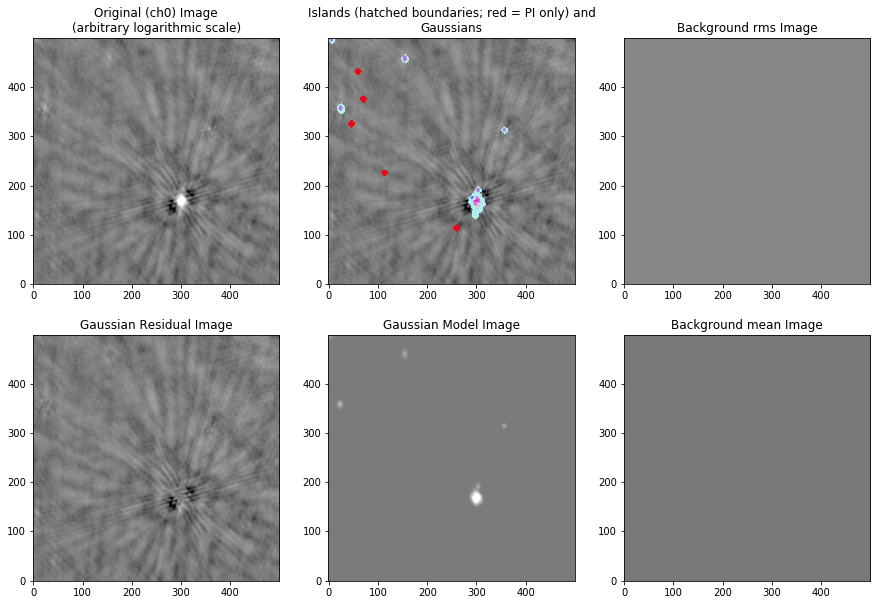

In [154]:
# img_mP.export_image(outfile='/home/alger/possum/beam4pi.pybdsf.fits', img_type='pi', clobber=True)
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
bdsf.plotresults.has_pl = True
bdsf.plotresults.pl = plt
bdsf.plotresults.cm = cm
bdsf.plotresults.Ellipse = Ellipse
bdsf.plotresults.collections = __import__('matplotlib').collections
bdsf.plotresults.plotresults(img_mP)
# img_mP.show_fit()

In [155]:
img_mP.write_catalog(format='csv')

--> Wrote ASCII file '/home/alger/possum/racs/image.snip.restored.all_stokes.SB8583.contcube.RACS_test4_1.05_0538-31A.beam04.pybdsm.gaul'


True

In [158]:
cat = pandas.read_csv(
    '/home/alger/possum/racs/image.snip.restored.all_stokes.SB8583.contcube.RACS_test4_1.05_0538-31A.beam04.pybdsm.gaul',
    skiprows=5)

In [172]:
with pandas.option_context('display.max_rows', 100, 'display.max_columns', 100):
    display(cat.T)

0            1            2            3  \
# Gaus_id                         0            1            2            3   
 Isl_id                           0            1            2            3   
 Source_id                        0            1            2            3   
 Wave_id                          0            0            0            0   
 RA                          83.531      83.5165      83.4107      83.2952   
 E_RA                   0.000333464   0.00026662   0.00046536  5.13143e-05   
 DEC                       -30.7002     -30.7984     -30.7284     -30.9328   
 E_DEC                   0.00075339  0.000493132  0.000953082  8.95694e-05   
 Total_flux              0.00657608   0.00783907   0.00710589    0.0757689   
 E_Total_flux            0.00177576   0.00165116   0.00211761   0.00219185   
 Peak_flux               0.00393252   0.00520345   0.00337126    0.0345385   
 E_Peak_flux            0.000704791  0.000710801  0.000712513  0.000717588   
 Xposn                      5.23025      23.9355      154.374      298.375   
 E_Xposn                   0.480134     0.383901     0.670074    0.0738902   
 Yposn                      498.603      357.297      458.695      164.978   
 E_Yposn                    1.08476     0.710011      1.37227     0.128955   
 Maj                      0.0083095    0.0074154   0.00922202   0.00914261   
 E_Maj                   0.00177441   0.00116151   0.00224974  0.000214441   
 Min                      0.0052166   0.00526643   0.00592466   0.00622018   
 E_Min                  0.000784668  0.000627394   0.00108482  0.000114474   
 PA                         178.668      178.368      4.23073      12.1132   
 E_PA                       19.7921      19.1612       25.003      2.56933   
 Maj_img_plane           0.00830849    0.0074143   0.00922072   0.00914066   
 E_Maj_img_plane         0.00177412   0.00116129   0.00224937  0.000214398   
 Min_img_plane           0.00521635   0.00526618   0.00592453   0.00622017   
 E_Min_img_plane        0.000784663  0.000627391   0.00108482  0.000114472   
 PA_img_plane               178.995      178.688      4.49645      12.3212   
 E_PA_img_plane              20.119      19.4817      25.2687      2.77729   
 DC_Maj                  0.00583428   0.00447003   0.00708668   0.00705377   
 E_DC_Maj                0.00177441   0.00116151   0.00224974  0.000214441   
 DC_Min                  0.00283179   0.00292191   0.00396528   0.00427964   
 E_DC_Min               0.000784668  0.000627394   0.00108482  0.000114474   
 DC_PA                       178.46      177.469      6.58569      18.4773   
 E_DC_PA                    19.7921      19.1612       25.003      2.56933   
 DC_Maj_img_plane        0.00583357   0.00446938   0.00708565   0.00705226   
 E_DC_Maj_img_plane      0.00177412   0.00116129   0.00224937  0.000214398   
 DC_Min_img_plane        0.00283165   0.00292176   0.00396521   0.00427964   
 E_DC_Min_img_plane     0.000784663  0.000627391   0.00108482  0.000114472   
 DC_PA_img_plane            178.787       177.79      6.85141      18.6852   
 E_DC_PA_img_plane           20.119      19.4817      25.2687      2.77729   
 Isl_Total_flux          0.00283934   0.00672351   0.00452554     0.155628   
 E_Isl_Total_flux       0.000547866  0.000735039  0.000687566   0.00237233   
 Isl_rms                0.000675985  0.000675985  0.000675985  0.000675985   
 Isl_mean              -1.89568e-05 -1.89568e-05 -1.89568e-05 -1.89568e-05   
 Resid_Isl_rms          5.49849e-05  0.000138293  5.27258e-05   0.00129104   
 Resid_Isl_mean        -1.86151e-05  -1.4623e-05 -1.86589e-05  0.000676384   
 S_Code                        S            S            S            M      
 Total_Q               -0.000191855 -6.01258e-05  0.000109741 -0.000744215   
 E_Total_Q              0.000225065  0.000209273  0.000268393  0.000277801   
 Total_U                -1.2348e-05  0.000137496 -0.000325249  0.000296052   
 E_Total_U              0.000218465  0.000203136  0.0002

In [160]:
print(', '.join(list(cat.columns)))

# Gaus_id,  Isl_id,  Source_id,  Wave_id,  RA,  E_RA,  DEC,  E_DEC,  Total_flux,  E_Total_flux,  Peak_flux,  E_Peak_flux,  Xposn,  E_Xposn,  Yposn,  E_Yposn,  Maj,  E_Maj,  Min,  E_Min,  PA,  E_PA,  Maj_img_plane,  E_Maj_img_plane,  Min_img_plane,  E_Min_img_plane,  PA_img_plane,  E_PA_img_plane,  DC_Maj,  E_DC_Maj,  DC_Min,  E_DC_Min,  DC_PA,  E_DC_PA,  DC_Maj_img_plane,  E_DC_Maj_img_plane,  DC_Min_img_plane,  E_DC_Min_img_plane,  DC_PA_img_plane,  E_DC_PA_img_plane,  Isl_Total_flux,  E_Isl_Total_flux,  Isl_rms,  Isl_mean,  Resid_Isl_rms,  Resid_Isl_mean,  S_Code,  Total_Q,  E_Total_Q,  Total_U,  E_Total_U,  Total_V,  E_Total_V,  Linear_Pol_frac,  Elow_Linear_Pol_frac,  Ehigh_Linear_Pol_frac,  Circ_Pol_Frac,  Elow_Circ_Pol_Frac,  Ehigh_Circ_Pol_Frac,  Total_Pol_Frac,  Elow_Total_Pol_Frac,  Ehigh_Total_Pol_Frac,  Linear_Pol_Ang,  E_Linear_Pol_Ang


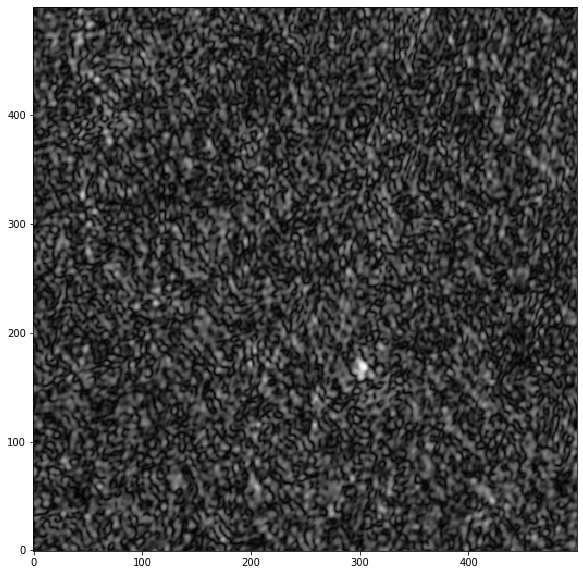

In [210]:
plt.figure(figsize=(10, 10))
plt.imshow(img_mP.ch0_pi_arr.T, cmap='Greys_r', origin='lower')

In [12]:
from RMutils import util_RM

In [194]:
mask = img_mP.pyrank + 1 > 0

In [14]:
# Q[0].header
freqs = numpy.arange(Q[0].header['CRVAL4'], Q[0].header['CRVAL4'] + Q[0].header['CDELT4'] * (Q[0].header['NAXIS4']), Q[0].header['CDELT4'])
assert len(freqs) == len(Q[0].data)
wls = (3e8 / freqs) ** 2
phis = numpy.linspace(-500, 500, 500)

In [11]:
fdf, fwhm = util_RM.do_rmsynth_planes(
    numpy.where(~mask, numpy.nan, snip[:, 1]), numpy.where(~mask, numpy.nan, snip[:, 2]), wls, phis,
    verbose=True)

NameError: name 'util_RM' is not defined

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/alger/mimsy/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-730c7e85b916>", line 1, in <module>
    fdf.shape
NameError: name 'fdf' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/alger/mimsy/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/alger/mimsy/conda/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/alger/mimsy/conda/lib/python3.7/sit

NameError: name 'fdf' is not defined

In [217]:
peak_fd = phis[abs(fdf).argmax(axis=0)]
peak_pi = abs(fdf).max(axis=0)

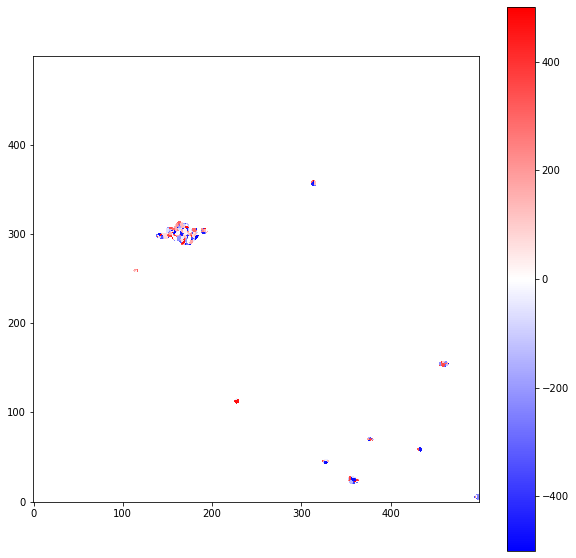

In [223]:
plt.figure(figsize=(10, 10))
plt.imshow(peak_fd * numpy.where(~mask, numpy.nan, 1), cmap='bwr', vmin=-500, vmax=500, origin='lower')
# plt.imshow(peak_pi, origin='lower')
plt.colorbar()

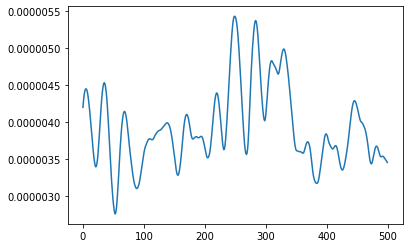

In [229]:
plt.plot(numpy.nanmean(abs(fdf)[:, 200:300, 100:200], axis=(1, 2)))


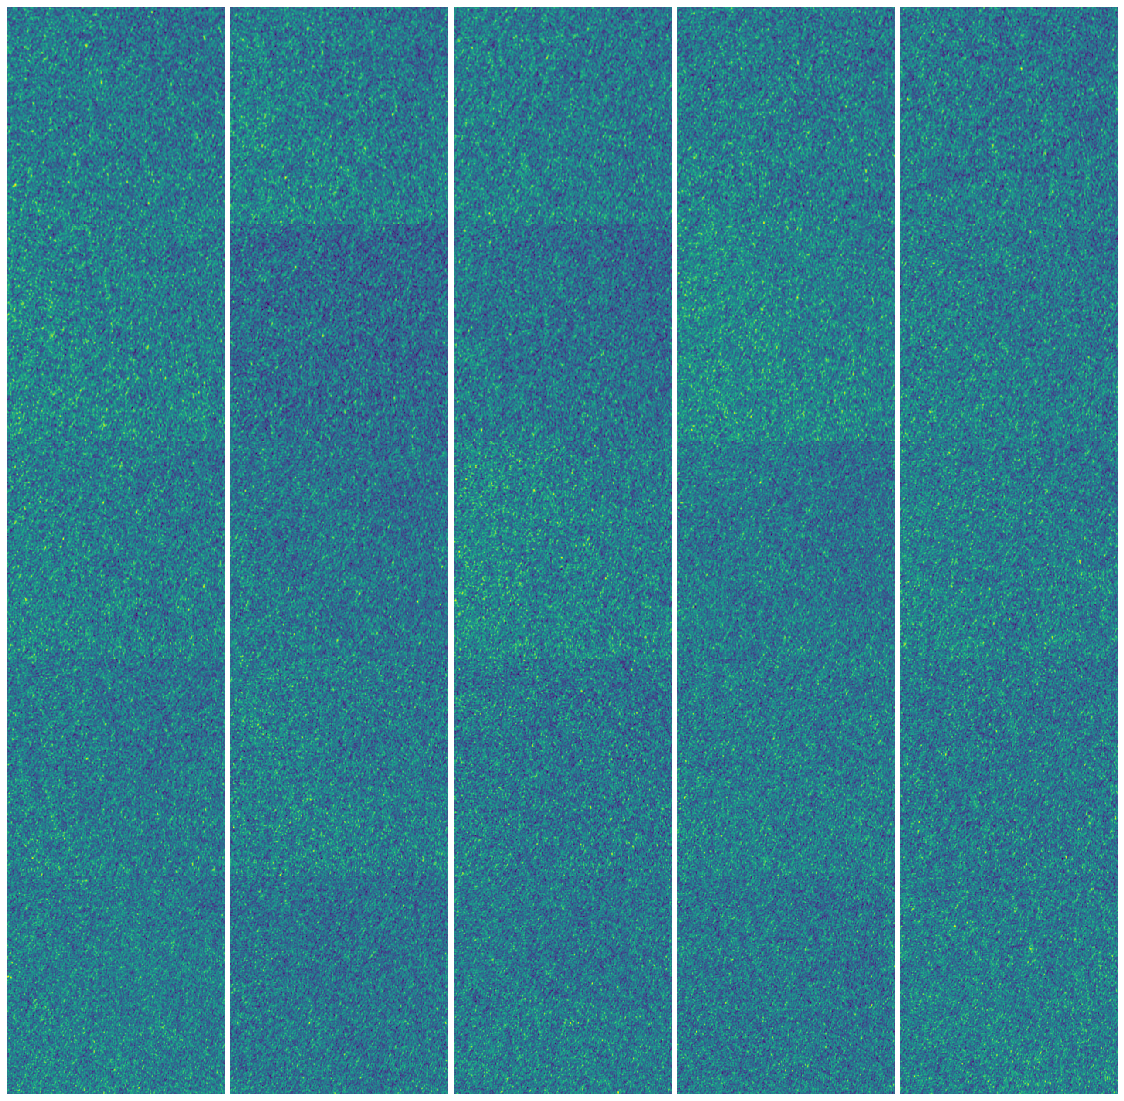

In [234]:
plt.figure(figsize=(20, 20))
for channel in range(25):
    plt.subplot(5, 5, channel + 1)
    plt.axis('off')
    plt.imshow(
        numpy.hypot(
            snip[channel * 10 : (channel + 1) * 10, 1], snip[channel * 10 : (channel + 1) * 10, 2]).mean(axis=0))
plt.subplots_adjust(hspace=0, wspace=0)

In [ ]:
stretch = vis.HistEqStretch()

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(stretch(img_mP.ch0_pi_arr.T), cmap='Greys_r', origin='lower')

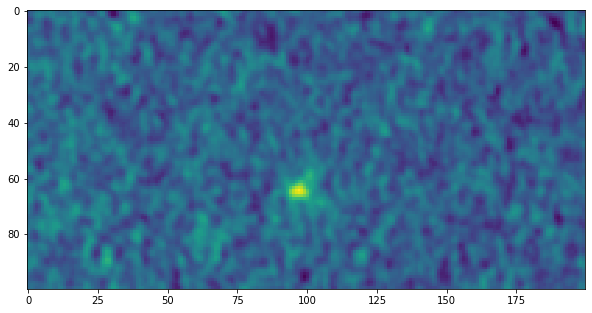

In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(numpy.hypot(snip[:, 1, 100:200, 200:400], snip[:, 2, 100:200, 200:400]).mean(axis=0))

In [244]:
average_snip = numpy.hypot(snip[:, 1], snip[:, 2])

(array([4.263443e+06, 7.812010e+05, 1.281449e+06, 1.752991e+06,
        2.179615e+06, 2.563953e+06, 2.891098e+06, 3.157397e+06,
        3.352505e+06, 3.493582e+06, 3.568593e+06, 3.583783e+06,
        3.545997e+06, 3.460856e+06, 3.329068e+06, 3.171020e+06,
        2.979101e+06, 2.771577e+06, 2.551426e+06, 2.323332e+06,
        2.095764e+06, 1.874657e+06, 1.662907e+06, 1.461954e+06,
        1.272119e+06, 1.096921e+06, 9.443660e+05, 8.009780e+05,
        6.769260e+05, 5.682830e+05, 4.733040e+05, 3.912400e+05,
        3.218540e+05, 2.631030e+05, 2.135960e+05, 1.732090e+05,
        1.403090e+05, 1.126010e+05, 8.947200e+04, 7.211100e+04,
        5.738700e+04, 4.618400e+04, 3.646000e+04, 2.922700e+04,
        2.361800e+04, 1.894600e+04, 1.505100e+04, 1.238400e+04,
        9.745000e+03, 8.197000e+03, 6.517000e+03, 5.348000e+03,
        4.342000e+03, 3.475000e+03, 2.870000e+03, 2.333000e+03,
        1.877000e+03, 1.491000e+03, 1.268000e+03, 1.015000e+03,
        8.130000e+02, 7.210000e+02, 5.75

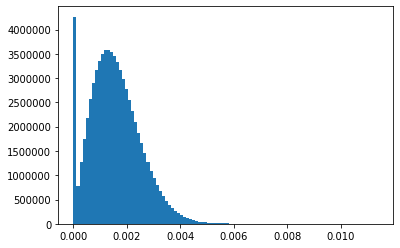

In [245]:
# plt.hist(img_mP.ch0_pi_arr.T.ravel(), bins=100);
# plt.hist(average_snip.ravel(), bins=100);
plt.hist(average_snip.ravel(), bins=100)

## Improvements?

Can we modify PyBDSF to not read the whole data into memory? It looks like it's only happening in one place, so maybe?

In [ ]:
img_mP = bdsf.process_image(
    f'/home/alger/possum/racs/image.restored.all_stokes.SB8583.contcube.RACS_test4_1.05_0538-31A.beam{beam}.fits',
    polarisation_do=True)

## Peak PI

(Canberra)

I'm curious as to why the peak PI map I ran on the CSIRO server looks so bad. Is this a RMtools quirk or a genuine issue? So let's see the peak PI map of this snip.

In [25]:
fdf, fwhm = util_RM.do_rmsynth_planes(
    snip[:, 1, 100:200, 200:400], snip[:, 2, 100:200, 200:400], wls, phis, verbose=True)

Q array: 0.02304 GB
U array: 0.02304 GB
Q shape: (288, 100, 200)
FDF allocation: 0.08 GB
Masking NaNs
Allocating FDF
Calculating K
Running RM-synthesis by channel.
Subdividing into 9                         ] 0%
RR...                                      ] 0%
II...
IR...
RI...
RR...                                      ] 0%
II...
IR...
RI...
RR...                                      ] 0%
II...
IR...
RI...
RR...                                      ] 0%
II...
IR...
RI...
RR...                                      ] 0%
II...
IR...
RI...
RR...                                      ] 0%
II...
IR...
RI...
RR...                                      ] 0%
II...
IR...
RI...
RR...                                      ] 0%
II...
IR...
RI...
RR...                                      ] 0%
II...
IR...
RI...
RR...                                      ] 0%
II...
IR...
RI...
RR...                                      ] 0%
II...
IR...
RI...
RR...                                      ] 0%
II...
IR...
RI

RR...                                      ] 1%
II...
IR...
RI...
RR...                                      ] 1%
II...
IR...
RI...
RR...                                      ] 1%
II...
IR...
RI...
RR...                                      ] 2%
II...
IR...
RI...
RR...                                      ] 2%
II...
IR...
RI...
RR...                                      ] 3%
II...
IR...
RI...
RR...                                      ] 0%
II...
IR...
RI...
RR...                                      ] 0%
II...
IR...
RI...
RR...                                      ] 1%
II...
IR...
RI...
RR...                                      ] 1%
II...
IR...
RI...
RR...                                      ] 1%
II...
IR...
RI...
RR...                                      ] 2%
II...
IR...
RI...
RR...                                      ] 2%
II...
IR...
RI...
RR...                                      ] 2%
II...
IR...
RI...
RR...                                      ] 3%
II...
IR...
RI...
RR...     

RR...=                                     ] 8%
II...
IR...
RI...
RR...                                      ] 0%
II...
IR...
RI...
RR...                                      ] 1%
II...
IR...
RI...
RR...                                      ] 2%
II...
IR...
RI...
RR...                                      ] 3%
II...
IR...
RI...
RR...                                      ] 4%
II...
IR...
RI...
RR...                                      ] 5%
II...
IR...
RI...
RR...                                      ] 6%
II...
IR...
RI...
RR...                                      ] 7%
II...
IR...
RI...
RR...=                                     ] 8%
II...
IR...
RI...
RR...                                      ] 0%
II...
IR...
RI...
RR...                                      ] 1%
II...
IR...
RI...
RR...                                      ] 2%
II...
IR...
RI...
RR...                                      ] 3%
II...
IR...
RI...
RR...                                      ] 4%
II...
IR...
RI...
RR...     

RR...                                      ] 6%
II...
IR...
RI...
RR...=                                     ] 7%
II...
IR...
RI...
RR...=                                     ] 9%
II...
IR...
RI...
RR...==                                    ] 10%
II...
IR...
RI...
RR...==                                    ] 12%
II...
IR...
RI...
RR...===                                   ] 14%
II...
IR...
RI...
RR...                                      ] 1%
II...
IR...
RI...
RR...                                      ] 3%
II...
IR...
RI...
RR...                                      ] 4%
II...
IR...
RI...
RR...                                      ] 6%
II...
IR...
RI...
RR...=                                     ] 7%
II...
IR...
RI...
RR...=                                     ] 9%
II...
IR...
RI...
RR...==                                    ] 10%
II...
IR...
RI...
RR...==                                    ] 12%
II...
IR...
RI...
RR...===                                   ] 14%
II...
IR...
RI...
RR..

RR...===                                   ] 14%
II...
IR...
RI...
RR...====                                  ] 17%
II...
IR...
RI...
RR...=====                                 ] 19%
II...
IR...
RI...
RR...                                      ] 2%
II...
IR...
RI...
RR...                                      ] 4%
II...
IR...
RI...
RR...                                      ] 6%
II...
IR...
RI...
RR...=                                     ] 8%
II...
IR...
RI...
RR...==                                    ] 10%
II...
IR...
RI...
RR...===                                   ] 12%
II...
IR...
RI...
RR...====                                  ] 15%
II...
IR...
RI...
RR...====                                  ] 17%
II...
IR...
RI...
RR...=====                                 ] 19%
II...
IR...
RI...
RR...                                      ] 2%
II...
IR...
RI...
RR...                                      ] 4%
II...
IR...
RI...
RR...                                      ] 6%
II...
IR...
RI...
RR

RR...                                      ] 2%
II...
IR...
RI...
RR...                                      ] 5%
II...
IR...
RI...
RR...=                                     ] 8%
II...
IR...
RI...
RR...==                                    ] 11%
II...
IR...
RI...
RR...===                                   ] 13%
II...
IR...
RI...
RR...====                                  ] 16%
II...
IR...
RI...
RR...=====                                 ] 19%
II...
IR...
RI...
RR...======                                ] 22%
II...
IR...
RI...
RR...========                              ] 25%
II...
IR...
RI...
RR...                                      ] 2%
II...
IR...
RI...
RR...                                      ] 5%
II...
IR...
RI...
RR...=                                     ] 8%
II...
IR...
RI...
RR...==                                    ] 11%
II...
IR...
RI...
RR...===                                   ] 13%
II...
IR...
RI...
RR...====                                  ] 16%
II...
IR...
RI...
R

RR...======                                ] 21%
II...
IR...
RI...
RR...=======                               ] 24%
II...
IR...
RI...
RR...=========                             ] 27%
II...
IR...
RI...
RR...                                      ] 3%
II...
IR...
RI...
RR...                                      ] 6%
II...
IR...
RI...
RR...=                                     ] 9%
II...
IR...
RI...
RR...==                                    ] 12%
II...
IR...
RI...
RR...====                                  ] 15%
II...
IR...
RI...
RR...=====                                 ] 18%
II...
IR...
RI...
RR...======                                ] 21%
II...
IR...
RI...
RR...=======                               ] 24%
II...
IR...
RI...
RR...=========                             ] 27%
II...
IR...
RI...
RR...                                      ] 3%
II...
IR...
RI...
RR...                                      ] 6%
II...
IR...
RI...
RR...=                                     ] 9%
II...
IR...
RI...
R

RR...===                                   ] 13%
II...
IR...
RI...
RR...====                                  ] 16%
II...
IR...
RI...
RR...======                                ] 20%
II...
IR...
RI...
RR...=======                               ] 23%
II...
IR...
RI...
RR...========                              ] 26%
II...
IR...
RI...
RR...==========                            ] 30%
II...
IR...
RI...
RR...                                      ] 3%
II...
IR...
RI...
RR...                                      ] 6%
II...
IR...
RI...
RR...==                                    ] 10%
II...
IR...
RI...
RR...===                                   ] 13%
II...
IR...
RI...
RR...====                                  ] 16%
II...
IR...
RI...
RR...======                                ] 20%
II...
IR...
RI...
RR...=======                               ] 23%
II...
IR...
RI...
RR...========                              ] 27%
II...
IR...
RI...
RR...==========                            ] 30%
II...
IR...
RI.

RR...=====                                 ] 19%
II...
IR...
RI...
RR...=======                               ] 23%
II...
IR...
RI...
RR...=========                             ] 27%
II...
IR...
RI...
RR...==========                            ] 31%
II...
IR...
RI...
RR...============                          ] 35%
II...
IR...
RI...
RR...                                      ] 3%
II...
IR...
RI...
RR...=                                     ] 7%
II...
IR...
RI...
RR...==                                    ] 11%
II...
IR...
RI...
RR...====                                  ] 15%
II...
IR...
RI...
RR...=====                                 ] 19%
II...
IR...
RI...
RR...=======                               ] 23%
II...
IR...
RI...
RR...=========                             ] 27%
II...
IR...
RI...
RR...==========                            ] 31%
II...
IR...
RI...
RR...============                          ] 36%
II...
IR...
RI...
RR...                                      ] 4%
II...
IR...
RI..

RR...========                              ] 27%
II...
IR...
RI...
RR...==========                            ] 31%
II...
IR...
RI...
RR...============                          ] 36%
II...
IR...
RI...
RR...==============                        ] 41%
II...
IR...
RI...
RR...                                      ] 4%
II...
IR...
RI...
RR...=                                     ] 9%
II...
IR...
RI...
RR...===                                   ] 13%
II...
IR...
RI...
RR...=====                                 ] 18%
II...
IR...
RI...
RR...=======                               ] 22%
II...
IR...
RI...
RR...========                              ] 27%
II...
IR...
RI...
RR...==========                            ] 32%
II...
IR...
RI...
RR...============                          ] 36%
II...
IR...
RI...
RR...==============                        ] 41%
II...
IR...
RI...
RR...                                      ] 4%
II...
IR...
RI...
RR...=                                     ] 9%
II...
IR...
RI...

RR...============                          ] 36%
II...
IR...
RI...
RR...==============                        ] 41%
II...
IR...
RI...
RR...================                      ] 46%
II...
IR...
RI...
RR...                                      ] 5%
II...
IR...
RI...
RR...==                                    ] 10%
II...
IR...
RI...
RR...====                                  ] 15%
II...
IR...
RI...
RR...======                                ] 20%
II...
IR...
RI...
RR...========                              ] 25%
II...
IR...
RI...
RR...==========                            ] 31%
II...
IR...
RI...
RR...============                          ] 36%
II...
IR...
RI...
RR...==============                        ] 41%
II...
IR...
RI...
RR...================                      ] 46%
II...
IR...
RI...
RR...                                      ] 5%
II...
IR...
RI...
RR...==                                    ] 10%
II...
IR...
RI...
RR...====                                  ] 15%
II...
IR...
RI.

RR...================                      ] 46%
II...
IR...
RI...
RR...==================                    ] 52%
II...
IR...
RI...
RR...                                      ] 5%
II...
IR...
RI...
RR...==                                    ] 11%
II...
IR...
RI...
RR...====                                  ] 17%
II...
IR...
RI...
RR...=======                               ] 23%
II...
IR...
RI...
RR...=========                             ] 28%
II...
IR...
RI...
RR...===========                           ] 34%
II...
IR...
RI...
RR...==============                        ] 40%
II...
IR...
RI...
RR...================                      ] 46%
II...
IR...
RI...
RR...==================                    ] 52%
II...
IR...
RI...
RR...                                      ] 5%
II...
IR...
RI...
RR...==                                    ] 11%
II...
IR...
RI...
RR...====                                  ] 17%
II...
IR...
RI...
RR...=======                               ] 23%
II...
IR...
RI.

RR...====================                  ] 57%
II...
IR...
RI...
RR...                                      ] 6%
II...
IR...
RI...
RR...===                                   ] 12%
II...
IR...
RI...
RR...=====                                 ] 19%
II...
IR...
RI...
RR...========                              ] 25%
II...
IR...
RI...
RR...==========                            ] 31%
II...
IR...
RI...
RR...=============                         ] 38%
II...
IR...
RI...
RR...===============                       ] 44%
II...
IR...
RI...
RR...==================                    ] 51%
II...
IR...
RI...
RR...=====================                 ] 57%
II...
IR...
RI...
RR...                                      ] 6%
II...
IR...
RI...
RR...===                                   ] 12%
II...
IR...
RI...
RR...=====                                 ] 19%
II...
IR...
RI...
RR...========                              ] 25%
II...
IR...
RI...
RR...==========                            ] 32%
II...
IR...
RI.

RR...                                      ] 6%
II...
IR...
RI...
RR...===                                   ] 13%
II...
IR...
RI...
RR...======                                ] 20%
II...
IR...
RI...
RR...=========                             ] 27%
II...
IR...
RI...
RR...===========                           ] 34%
II...
IR...
RI...
RR...==============                        ] 41%
II...
IR...
RI...
RR...=================                     ] 48%
II...
IR...
RI...
RR...====================                  ] 55%
II...
IR...
RI...
RR...=======================               ] 63%
II...
IR...
RI...
RR...                                      ] 7%
II...
IR...
RI...
RR...===                                   ] 14%
II...
IR...
RI...
RR...======                                ] 21%
II...
IR...
RI...
RR...=========                             ] 28%
II...
IR...
RI...
RR...============                          ] 35%
II...
IR...
RI...
RR...==============                        ] 42%
II...
IR...
RI.

RR...====                                  ] 15%
II...
IR...
RI...
RR...=======                               ] 22%
II...
IR...
RI...
RR...==========                            ] 30%
II...
IR...
RI...
RR...=============                         ] 37%
II...
IR...
RI...
RR...================                      ] 45%
II...
IR...
RI...
RR...===================                   ] 53%
II...
IR...
RI...
RR...======================                ] 60%
II...
IR...
RI...
RR...=========================             ] 68%
II...
IR...
RI...
RR...=                                     ] 7%
II...
IR...
RI...
RR...====                                  ] 15%
II...
IR...
RI...
RR...=======                               ] 22%
II...
IR...
RI...
RR...==========                            ] 30%
II...
IR...
RI...
RR...=============                         ] 38%
II...
IR...
RI...
RR...================                      ] 45%
II...
IR...
RI...
RR...===================                   ] 53%
II...
IR...
RI

RR...=======                               ] 24%
II...
IR...
RI...
RR...===========                           ] 32%
II...
IR...
RI...
RR...==============                        ] 40%
II...
IR...
RI...
RR...=================                     ] 49%
II...
IR...
RI...
RR...====================                  ] 57%
II...
IR...
RI...
RR...========================              ] 65%
II...
IR...
RI...
RR...===========================           ] 73%
II...
IR...
RI...
RR...=                                     ] 8%
II...
IR...
RI...
RR...====                                  ] 16%
II...
IR...
RI...
RR...=======                               ] 24%
II...
IR...
RI...
RR...===========                           ] 32%
II...
IR...
RI...
RR...==============                        ] 41%
II...
IR...
RI...
RR...=================                     ] 49%
II...
IR...
RI...
RR...====================                  ] 57%
II...
IR...
RI...
RR...========================              ] 65%
II...
IR...
RI

RR...============                          ] 35%
II...
IR...
RI...
RR...===============                       ] 43%
II...
IR...
RI...
RR...===================                   ] 52%
II...
IR...
RI...
RR...======================                ] 61%
II...
IR...
RI...
RR...==========================            ] 70%
II...
IR...
RI...
RR...=============================         ] 79%
II...
IR...
RI...
RR...=                                     ] 8%
II...
IR...
RI...
RR...=====                                 ] 17%
II...
IR...
RI...
RR...========                              ] 26%
II...
IR...
RI...
RR...============                          ] 35%
II...
IR...
RI...
RR...===============                       ] 44%
II...
IR...
RI...
RR...===================                   ] 52%
II...
IR...
RI...
RR...======================                ] 61%
II...
IR...
RI...
RR...==========================            ] 70%
II...
IR...
RI...
RR...=============================         ] 79%
II...
IR...
RI

RR...================                      ] 46%
II...
IR...
RI...
RR...====================                  ] 56%
II...
IR...
RI...
RR...========================              ] 65%
II...
IR...
RI...
RR...============================          ] 75%
II...
IR...
RI...
RR...===============================       ] 84%
II...
IR...
RI...
RR...=                                     ] 9%
II...
IR...
RI...
RR...=====                                 ] 18%
II...
IR...
RI...
RR...=========                             ] 28%
II...
IR...
RI...
RR...=============                         ] 37%
II...
IR...
RI...
RR...================                      ] 47%
II...
IR...
RI...
RR...====================                  ] 56%
II...
IR...
RI...
RR...========================              ] 65%
II...
IR...
RI...
RR...============================          ] 75%
II...
IR...
RI...
RR...===============================       ] 84%
II...
IR...
RI...
RR...=                                     ] 9%
II...
IR...
RI.

RR...=====================                 ] 59%
II...
IR...
RI...
RR...=========================             ] 69%
II...
IR...
RI...
RR...=============================         ] 79%
II...
IR...
RI...
RR...==================================    ] 90%
II...
IR...
RI...
RR...==                                    ] 10%
II...
IR...
RI...
RR...======                                ] 20%
II...
IR...
RI...
RR...==========                            ] 30%
II...
IR...
RI...
RR...==============                        ] 40%
II...
IR...
RI...
RR...==================                    ] 50%
II...
IR...
RI...
RR...======================                ] 60%
II...
IR...
RI...
RR...==========================            ] 70%
II...
IR...
RI...
RR...==============================        ] 80%
II...
IR...
RI...
RR...==================================    ] 90%
II...
IR...
RI...
RR...==                                    ] 10%
II...
IR...
RI...
RR...======                                ] 20%
II...
IR...
R

RR...===========================           ] 74%
II...
IR...
RI...
RR...===============================       ] 84%
II...
IR...
RI...
RR...====================================  ] 95%
II...
IR...
RI...
RR...==                                    ] 10%
II...
IR...
RI...
RR...======                                ] 21%
II...
IR...
RI...
RR...==========                            ] 31%
II...
IR...
RI...
RR...==============                        ] 42%
II...
IR...
RI...
RR...===================                   ] 53%
II...
IR...
RI...
RR...=======================               ] 63%
II...
IR...
RI...
RR...===========================           ] 74%
II...
IR...
RI...
RR...===============================       ] 84%
II...
IR...
RI...
RR...====================================  ] 95%
II...
IR...
RI...
RR...==                                    ] 10%
II...
IR...
RI...
RR...======                                ] 21%
II...
IR...
RI...
RR...==========                            ] 31%
II...
IR...
R

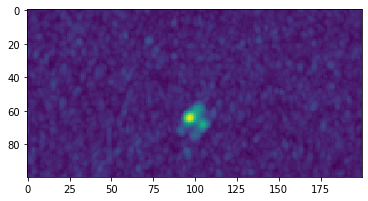

In [48]:
plt.imshow(numpy.max(abs(fdf), axis=0))